# MD example - Lammps

In [1]:
# headers

# general modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import physical_constants

# pyiron modules
from pyiron_atomistics import Project
import pyiron_contrib

# conversion factors
KB = physical_constants['Boltzmann constant in eV/K'][0]
GPA_TO_BAR = 1e4

In [2]:
# project

pr = Project('md_test')
pr.remove_jobs_silently(recursive=True)

In [3]:
# basics

# structure specific
element = 'Al'
supercell = 3
cubic = True

# job specific
potential = '2008--Mendelev-M-I--Al--LAMMPS--ipr1'

# MD specific
temperature = 900. # K
pressure = 0.  # GPa
temperature_damping_timescale = 100.
pressure_damping_timescale = 1000.
timestep = 1.
n_steps = 5000

In [4]:
# create base structure

box = pr.create_ase_bulk(name=element, cubic=cubic).repeat(supercell)
n_atoms = box.get_number_of_atoms()

In [5]:
# create and run the NEB job

pr_prot = pr.create_group('protocol_md')  # create a new folder

md_ref = pr_prot.create_job(pr.job_type.Lammps, 'ref_md')
md_ref.structure = box
md_ref.potential = potential
md_ref.save()  # Don't forget this step!

# The same notebook should work for the other MD protocols:
# ProtoHarmMD: atoms behave as quantum-harmonic oscillators. Specify a spring or a force constant matrix!
# NOTE: ProtoHarmMD does not output pressure and volume, so some cells below may throw errors!
# ProtoConfinedMD: Regular MD, but atoms do not leave their lattice sites in the presence of a vacancy.
prot_md_job = pr_prot.create_job(pr.job_type.ProtoMD, 'prot_md_job')
prot_md_job.input.ref_job_full_path = md_ref.path
prot_md_job.input.structure = box
prot_md_job.input.temperature = temperature
prot_md_job.input.pressure = pressure  # not necessary for ProtoHarmMD!
prot_md_job.input.n_steps = n_steps
prot_md_job.input.temperature_damping_timescale = temperature_damping_timescale
prot_md_job.input.pressure_damping_timescale = pressure_damping_timescale  # not necessary for ProtoHarmMD!
prot_md_job.input.timestep = timestep

# prot_md_job.server.queue = 'cmti'
# prot_md_job.server.cores = 4
# prot_md_job.server.run_time = 3600

# set_output_whitelist sets how often an output of a particular vertex is stored in the archive.
# for example, here, the output 'volume' of vertex 'calc_static' is saved every 10 steps in the archive.
prot_md_job.set_output_whitelist(**
    {
    'barostat': {'pressure': 10},
    'verlet_velocities': {'energy_kin': 10},
    'calc_static': {'volume': 10}
    }
)  # ProtoHarmMD does not have 'barostat' and 'calc_static'!

prot_md_job.run()

The job ref_md was saved and received the ID: 588
The job prot_md_job was saved and received the ID: 589
The job prot_md_job_calc_static_job was saved and received the ID: 590


/home/raynol025/pyiron/pyiron_base/pyiron_base/generic/parameters.py:284: UserWarning: The input in GenericParameters changed, while the state of the job was already finished.
  "The input in GenericParameters changed, while the state of the job was already finished."
/home/raynol025/pyiron/pyiron/pyiron/lammps/interactive.py:108: UserWarning: Warning: setting upper trangular matrix might slow down the calculation
  "Warning: setting upper trangular matrix might slow down the calculation"


In [6]:
# check what keys are in the output dictionary

prot_md_job.output.keys()

dict_keys(['energy_pot', 'energy_kin', 'positions', 'velocities', 'forces', 'pressure', 'volume'])

In [7]:
# run pyiron's lammps md

pr_pyir = pr.create_group('pyiron_md')

pyir_md_job = pr.create_job(pr.job_type.Lammps, 'pyir_md_job')
pyir_md_job.structure = box
pyir_md_job.potential = potential
pyir_md_job.calc_md(temperature=temperature, n_ionic_steps=n_steps, n_print=10, langevin=True)
# get lammps to use the berendsen barostat
pyir_md_job.input.control['fix'] = '1 all press/berendsen iso ' + str(pressure * GPA_TO_BAR) + \
                            ' ' + str(pressure * GPA_TO_BAR) + ' ' + str(pressure_damping_timescale)
pyir_md_job.run()

The job pyir_md_job was saved and received the ID: 591


In [8]:
# main output protocol

protocol_volume = prot_md_job.graph.calc_static.archive.output.volume.data
protocol_pressure = prot_md_job.graph.barostat.archive.output.pressure.data
e_kin_md = np.array(prot_md_job.graph.verlet_velocities.archive.output.energy_kin.data)
protocol_temperature = (2. * prot_md_job.graph.verlet_velocities.archive.output.energy_kin.data) / (3 * KB * n_atoms)

onwards = 2
lattice_constant_protocol = np.cbrt(protocol_volume[onwards:]) / supercell

In [9]:
# main output lammps

lammps_volume = pyir_md_job.output.volume
lammps_pressure = [np.trace(p) for p in pyir_md_job.output.pressures]
lammps_temperature = pyir_md_job.output.temperature

lattice_constant_lammps = np.cbrt(lammps_volume[onwards:]) / supercell

RESULTS

Mean a protocol:  4.131081087250005
Mean a lammps:  4.134876908825429

Std a protocol:  0.005121686219488185
Std a lammps:  0.007008599297580372


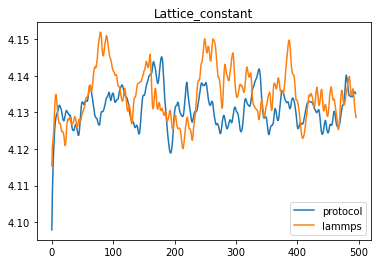

Mean P protocol:  0.02386987600798911
Mean P lammps:  0.026129021330917997

Std P protocol:  0.240921358205039
Std P lammps:  0.397850253148556


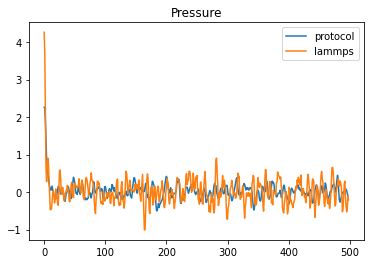

Mean T protocol:  877.0596505504095
Mean T lammps:  904.6031802569803

Std T protocol:  67.37817160297706
Std T lammps:  74.3175831397155


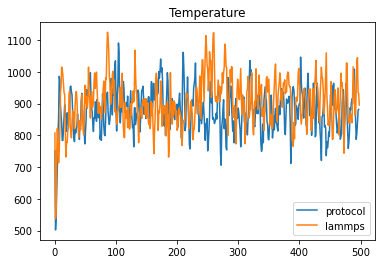

In [10]:
# comparison plots

print('RESULTS\n')

plt.title('Lattice_constant')
plt.plot(lattice_constant_protocol[onwards:], label='protocol')
plt.plot(lattice_constant_lammps[onwards:], label='lammps')
print('Mean a protocol: ', np.mean(lattice_constant_protocol[onwards:]))
print('Mean a lammps: ', np.mean(lattice_constant_lammps[onwards:]))
print('\nStd a protocol: ', np.std(lattice_constant_protocol[onwards:]))
print('Std a lammps: ', np.std(lattice_constant_lammps[onwards:]))
plt.legend()
plt.show()

plt.title('Pressure')
plt.plot(protocol_pressure[onwards:], label='protocol')
plt.plot(lammps_pressure[onwards:], label='lammps')
print('Mean P protocol: ', np.mean(protocol_pressure[onwards:]))
print('Mean P lammps: ', np.mean(lammps_pressure[onwards:]))
print('\nStd P protocol: ', np.std(protocol_pressure[onwards:]))
print('Std P lammps: ', np.std(lammps_pressure[onwards:]))
plt.legend()
plt.show()

plt.title('Temperature')
plt.plot(protocol_temperature[onwards:], label='protocol')
plt.plot(lammps_temperature[onwards:], label='lammps')
print('Mean T protocol: ', np.mean(protocol_temperature[onwards:]))
print('Mean T lammps: ', np.mean(lammps_temperature[onwards:]))
print('\nStd T protocol: ', np.std(protocol_temperature[onwards:]))
print('Std T lammps: ', np.std(lammps_temperature[onwards:]))
plt.legend()
plt.show()